<a href="https://colab.research.google.com/github/pwliuab/MachineLearning-fake-news-detection/blob/main/pa3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd


In [ ]:
df_train = pd.read_csv('gdrive/MyDrive/pa3/train.csv')
df_test = pd.read_csv('gdrive/MyDrive/pa3/test.csv')

print(df_train.shape)

(12375, 2)


### Split the data into train and test, while test contains 1000 '1' , and 1000 '0'

In [ ]:
from sklearn.model_selection import train_test_split
df_train = pd.read_csv('gdrive/MyDrive/pa3/train.csv')
df_test = pd.read_csv('gdrive/MyDrive/pa3/test.csv')
print((df_train == 0).sum(axis=0)[0])
df_train_0 = df_train[0:(df_train == 0).sum(axis=0)[0]] # divide the training set into "0"
df_train_1 = df_train[(df_train == 0).sum(axis=0)[0]:] # get the labels with "1"
# split data seperately to get "1" and "0" validation set.
train_data_0, val_data_0 = train_test_split(df_train_0, test_size=1000, random_state=4211, shuffle=True)
train_data_1, val_data_1 = train_test_split(df_train_1, test_size=1000, random_state=4211, shuffle=True)

train_data = train_data_0.append(train_data_1, ignore_index =True)
val_data = val_data_0.append(val_data_1, ignore_index=True)

train_table = train_data.iloc[:,0]
train_data = train_data.iloc[:,-1]

val_table = val_data.iloc[:,0]
val_data = val_data.iloc[:,-1]

train_data = pd.concat([train_data, train_table], axis=1)
val_data = pd.concat([val_data, val_table], axis=1)

9375


In [ ]:
!pip install -U torchtext==0.6.0

#if you are using colab please, install torchtext.


     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 1.2MB 10.5MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator
import torch

import nltk
nltk.download('punkt')
from nltk import word_tokenize

train_data.to_csv('gdrive/My Drive/new_train.csv', index=False)
val_data.to_csv('gdrive/MyDrive/val.csv', index=False)


txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) # "i like the moive" -> "i", "like", "the", "movie"
label_field = Field(sequential=False, use_vocab=False, batch_first=True) #0, 1

# make splits for data
train, test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', txt_field),('label', label_field)], skip_header=True)

# build the vocabulary on the training set only, 
txt_field.build_vocab(train, min_freq=2)
#label_field.build_vocab(train)

# make iterator for splits
# sort_within_batch true, inorder to sort using sort_key, in decending order.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Q1 count the unique OOV 

In [ ]:
import tensorflow as tf
import torch
def tf_count(t):

  data = BucketIterator(t, batch_size=len(t.examples), sort_key=lambda x: len(x.sentence),sort_within_batch=True)
  batch = next(iter(data))
  sent,_ = batch.sentence
  print(torch.count_nonzero(sent))
  print(torch.numel(sent))
  ans = torch.numel(sent) - torch.count_nonzero(sent)
  return ans

# difference between validation dictionary and training dictionary
def count_unique(dictionary, choice):
  vocab_list = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True)
  temp_label = Field(sequential=False, use_vocab=False, batch_first=True) #0, 1
  temp_train, temp_test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', vocab_list),('label', temp_label)], skip_header=True)
  if choice == 'test':
    vocab_list.build_vocab(temp_test, min_freq=1)

  else:
    vocab_list.build_vocab(temp_train, min_freq=1)

  ans_test = len(list(set(vocab_list.vocab.itos)- set(dictionary.vocab.itos)))
  return ans_test

print("The OOV in training set: ",count_unique(txt_field,'train'))
print("The OOV in validation set: ",count_unique(txt_field,'test'))

The OOV in training set:  8650
The OOV in validation set:  2740


### show the train and test example, check the process.

In [ ]:
print(f'Number of training samples: {len(train.examples)}')
print(f'Number of testing samples: {len(test.examples)}')

print(f'Example of training data:\n {vars(train.examples[0])}\n')
print(f'Example of testing data:\n {vars(test.examples[1])}\n')

batch = next(iter(train_iter))
print('label tensor', batch.label.shape)
print(batch)
print(batch.label)
print()
sent, sent_len = batch.sentence
print('sentence length tensor', sent_len.shape)
print(sent_len)
print('sentence tensor', sent.shape)
print(sent)

Number of training samples: 10375
Number of testing samples: 2000
Example of training data:
 {'sentence': ['source', ':', 'qatar', 'asks', 'hamas', 'to', 'cease', 'terror', 'planning', 'from', 'its', 'territory'], 'label': '0'}

Example of testing data:
 {'sentence': ['hillary', 'clinton', 'receives', 'ovation', 'at', '‘', 'the', 'color', 'purple', '’'], 'label': '0'}

label tensor torch.Size([64])

[torchtext.data.batch.Batch of size 64]
	[.sentence]:('[torch.LongTensor of size 64x11]', '[torch.LongTensor of size 64]')
	[.label]:[torch.LongTensor of size 64]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

sentence length tensor torch.Size([64])
tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 

### Q2

In [ ]:
import torch.nn as nn
class Text_RNN(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.RNN(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()
    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)

        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 




#Q2 Counting the trainable parameter
def count_parameters(model):
  total_params = sum(para.numel() for para in model.parameters() if para.requires_grad)
  return total_params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Text_RNN(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
print("The total learnable parameters :", count_parameters(model))
print("The whole architecture: ", model)

The total learnable parameters : 405139
The whole architecture:  Text_RNN(
  (emb): Embedding(7953, 50)
  (rnn): RNN(50, 64, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Q3. showing the Train , Val, and Plot graph of the validation loss.

In [ ]:
def save_checkpoint(save_path, model, optimizer, val_loss, val_accur):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss,
                  'val_accuracy': val_accur
                  }

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    val_accur = state_dict['val_accuracy']
    print(f'Model loaded from {save_path}, and best val accuracy {val_accur}')
    return val_accur



def TRAIN(model, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss, device, save_name, train_report, val_report):
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        print('Resume training')
    
    model.to(device)
    best_val_accur = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        corr = 0
        for i, (inputs) in enumerate(train_loader):
            model.train()
            inputs = inputs
            # labels = labels
            # print("The type of inputs are:",inputs)
            # '''Training of the model'''
            # # Forward pass
            sent, sent_len = inputs.sentence
            labels = inputs.label

            sent = sent.to(device)
            sent_len = sent_len.to('cpu')

            labels = labels.to(device)
            labels = labels.unsqueeze(1)

            outputs = model(sent,sent_len)
            outputs = outputs.squeeze(0)
            loss = criterion(outputs.float(), labels.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_report.append(train_loss)

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            for i, (inputs) in enumerate(valid_loader):
                model.eval()

                sent, sent_len = inputs.sentence
                labels = inputs.label

                sent = sent.to(device)
                sent_len = sent_len.to('cpu')

                labels = labels.to(device)
                outputs = model(sent,sent_len)
                
                labels = labels.unsqueeze(1)
                outputs = outputs.squeeze(0)
                loss = criterion(outputs.float(), labels.float())

                running_loss += loss.item()
                
                for j in range(len(outputs)):
                  if labels[j] == 1 and outputs[j] >= 0.5 :
                    corr += 1
                  if labels[j] == 0 and outputs[j] < 0.5 :
                    corr += 1
            val_loss = running_loss / len(valid_loader)
            val_report.append(val_loss)
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Valid accuracy{:.4f}' 
                  .format(epoch+1, num_epochs, train_loss, val_loss, corr/2000))
            val_accur = corr/2000
            if val_accur > best_val_accur:
                best_val_accur = val_accur
                save_checkpoint(save_name, model, optimizer, val_loss, corr/2000)
                    
    print('Finished Training')

In [ ]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

train, test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', txt_field),('label', label_field)], skip_header=True)

txt_field.build_vocab(train, min_freq=2)

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)


n_epochs = 15
val_loss = None
save_name = 'baseline_model'
criterion = nn.BCELoss()
val_report_base = []
train_report_base = []
model = Text_RNN(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer = Adam(model.parameters())
#start training
TRAIN(model, train_iter, test_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_base, val_report_base)

Epoch [1/15], Train Loss: 0.4710, Valid Loss: 0.6666, Valid accuracy0.6305
Model saved to baseline_model
Epoch [2/15], Train Loss: 0.4054, Valid Loss: 0.7280, Valid accuracy0.6345
Model saved to baseline_model
Epoch [3/15], Train Loss: 0.3498, Valid Loss: 0.6565, Valid accuracy0.7045
Model saved to baseline_model
Epoch [4/15], Train Loss: 0.3085, Valid Loss: 0.6165, Valid accuracy0.7280
Model saved to baseline_model
Epoch [5/15], Train Loss: 0.2613, Valid Loss: 0.6163, Valid accuracy0.7480
Model saved to baseline_model
Epoch [6/15], Train Loss: 0.2238, Valid Loss: 0.5951, Valid accuracy0.7555
Model saved to baseline_model
Epoch [7/15], Train Loss: 0.1906, Valid Loss: 0.6522, Valid accuracy0.7485
Epoch [8/15], Train Loss: 0.1627, Valid Loss: 0.6580, Valid accuracy0.7705
Model saved to baseline_model
Epoch [9/15], Train Loss: 0.1350, Valid Loss: 0.7390, Valid accuracy0.7650
Epoch [10/15], Train Loss: 0.1126, Valid Loss: 0.7953, Valid accuracy0.7565
Epoch [11/15], Train Loss: 0.0928, Vali

Model loaded from gdrive/MyDrive/baseline_model, and best val accuracy 0.7835


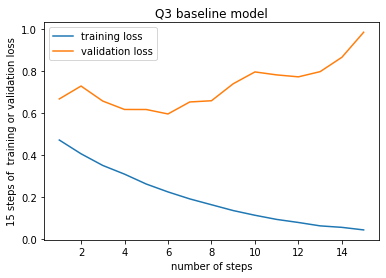

In [ ]:
import matplotlib.pyplot as plt
load_checkpoint("gdrive/MyDrive/baseline_model",model ,optimizer)
plt.plot(range(1, len(train_report_base)+1, 1), train_report_base,label="training loss")
plt.plot(range(1, len(val_report_base)+1, 1), val_report_base,label="validation loss")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.title("Q3 baseline model")
plt.legend()
plt.show()

### Q4 GRU model1

In [ ]:
import torch.nn as nn
class Text_RNN_1(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_1, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.GRU = nn.GRU(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=False
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.GRU(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.GRU(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)

        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 


In [ ]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'# if you got cuda error just run using cpu
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

train, test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', txt_field),('label', label_field)], skip_header=True)
txt_field.build_vocab(train, min_freq=2)

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
val_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
## The above are the initialization, avoid having modification before.

n_epochs = 15
val_loss = None

save_name = 'model_1_GRU_model'
criterion = nn.BCELoss()
val_report_model1 = []
train_report_model1 = []
GRU_model = Text_RNN_1(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer = Adam(GRU_model.parameters())
#start training
TRAIN(GRU_model, train_iter, val_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_model1, val_report_model1)

Epoch [1/15], Train Loss: 0.4830, Valid Loss: 0.6829, Valid accuracy0.6200
Model saved to model_1_GRU_model
Epoch [2/15], Train Loss: 0.3908, Valid Loss: 0.7098, Valid accuracy0.6455
Model saved to model_1_GRU_model
Epoch [3/15], Train Loss: 0.3071, Valid Loss: 0.5775, Valid accuracy0.7305
Model saved to model_1_GRU_model
Epoch [4/15], Train Loss: 0.2430, Valid Loss: 0.5982, Valid accuracy0.7550
Model saved to model_1_GRU_model
Epoch [5/15], Train Loss: 0.1980, Valid Loss: 0.5440, Valid accuracy0.7720
Model saved to model_1_GRU_model
Epoch [6/15], Train Loss: 0.1578, Valid Loss: 0.5252, Valid accuracy0.7825
Model saved to model_1_GRU_model
Epoch [7/15], Train Loss: 0.1249, Valid Loss: 0.6359, Valid accuracy0.7635
Epoch [8/15], Train Loss: 0.0927, Valid Loss: 0.6699, Valid accuracy0.7760
Epoch [9/15], Train Loss: 0.0670, Valid Loss: 0.7804, Valid accuracy0.7740
Epoch [10/15], Train Loss: 0.0461, Valid Loss: 0.9692, Valid accuracy0.7645
Epoch [11/15], Train Loss: 0.0305, Valid Loss: 0.99

Model loaded from model_1_GRU_model, and best val accuracy 0.7855


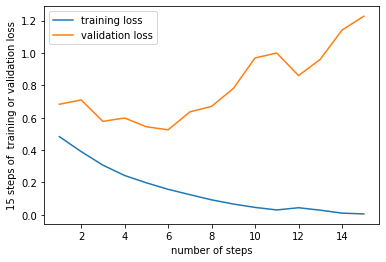

In [ ]:
import matplotlib.pyplot as plt
load_checkpoint('model_1_GRU_model',GRU_model,optimizer)
plt.plot(range(1, len(train_report_model1)+1, 1), train_report_model1,label="training loss")
plt.plot(range(1, len(val_report_model1)+1, 1), val_report_model1,label="validation loss")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.legend()
plt.show()

### Q4 MODEL 2 , LSTM WITHOUT BIDIRECTIONAL

In [ ]:
import torch.nn as nn
class Text_RNN_2(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_2, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.LSTM = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=False
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        # outputs, hidden = self.LSTM(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        no_need, (hidden,_) = self.LSTM(packed_embedded)
        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)

        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 


In [ ]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

train, test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', txt_field),('label', label_field)], skip_header=True)
txt_field.build_vocab(train, min_freq=2)

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
val_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
## The above are the initialization, avoid having modification before.

n_epochs = 15
val_loss = None

save_name = 'LSTM_model_2'
criterion = nn.BCELoss()
val_report_model2 = []
train_report_model2 = []
LSTM_1_model = Text_RNN_2(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer = Adam(LSTM_1_model.parameters())
#start training
TRAIN(LSTM_1_model, train_iter, val_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_model2, val_report_model2)

Epoch [1/15], Train Loss: 0.4956, Valid Loss: 0.6785, Valid accuracy0.6115
Model saved to LSTM_model_2
Epoch [2/15], Train Loss: 0.3882, Valid Loss: 0.7429, Valid accuracy0.6405
Model saved to LSTM_model_2
Epoch [3/15], Train Loss: 0.3112, Valid Loss: 0.5418, Valid accuracy0.7455
Model saved to LSTM_model_2
Epoch [4/15], Train Loss: 0.2488, Valid Loss: 0.5734, Valid accuracy0.7555
Model saved to LSTM_model_2
Epoch [5/15], Train Loss: 0.2057, Valid Loss: 0.5090, Valid accuracy0.7875
Model saved to LSTM_model_2
Epoch [6/15], Train Loss: 0.1668, Valid Loss: 0.5060, Valid accuracy0.7920
Model saved to LSTM_model_2
Epoch [7/15], Train Loss: 0.1310, Valid Loss: 0.6188, Valid accuracy0.7655
Epoch [8/15], Train Loss: 0.0970, Valid Loss: 0.6164, Valid accuracy0.7750
Epoch [9/15], Train Loss: 0.0743, Valid Loss: 0.8132, Valid accuracy0.7720
Epoch [10/15], Train Loss: 0.0587, Valid Loss: 0.8534, Valid accuracy0.7520
Epoch [11/15], Train Loss: 0.0454, Valid Loss: 0.8475, Valid accuracy0.7755
Epoch

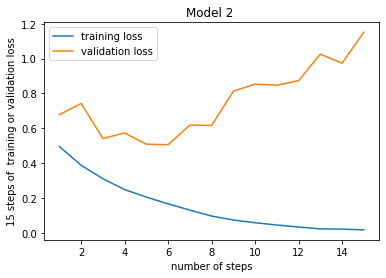

In [ ]:
#Q4 plot figure
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_model2)+1, 1), train_report_model2,label="training loss")
plt.plot(range(1, len(val_report_model2)+1, 1), val_report_model2,label="validation loss")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.title("Model 2 ")
plt.legend()
plt.show()

### Q5 comapres the GRU and LSTM with baseline RNN

Model loaded from gdrive/MyDrive/baseline_model, and best val accuracy 0.7835
Model loaded from gdrive/MyDrive/model_1_GRU_model, and best val accuracy 0.7855
Model loaded from gdrive/MyDrive/LSTM_model_2, and best val accuracy 0.792


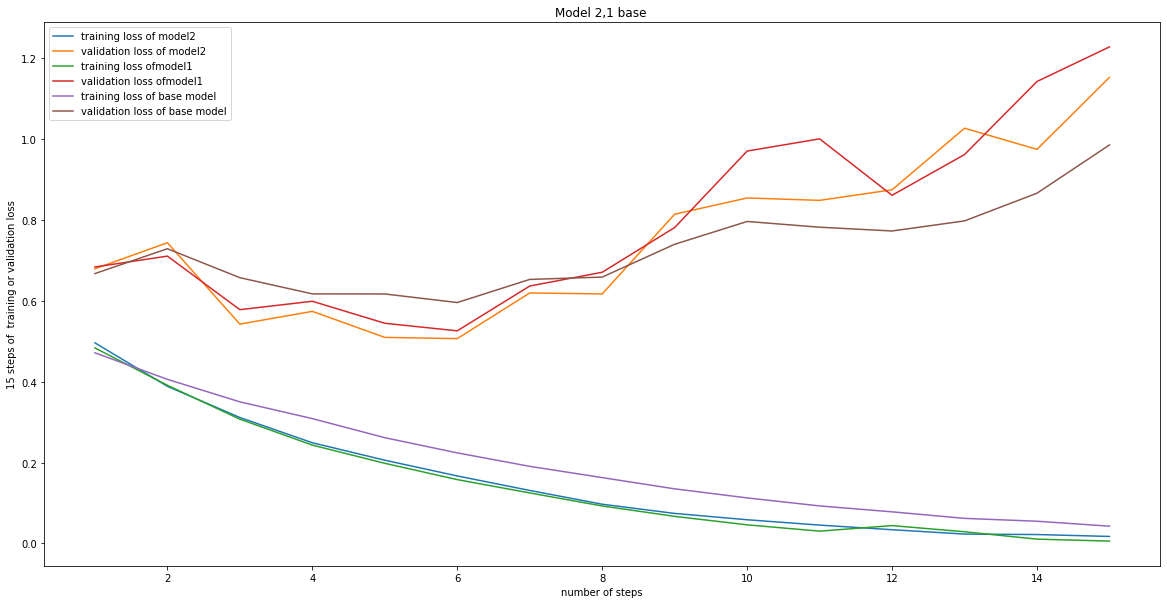

In [ ]:
from torch.optim import Adam
fig = plt.figure(figsize=(20, 10))

PATH1 = 'gdrive/MyDrive/baseline_model'# you may change this path to directory that stores rnn_model
PATH2= 'gdrive/MyDrive/model_1_GRU_model'
PATH3 = 'gdrive/MyDrive/LSTM_model_2'
model = Text_RNN(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer1 = Adam(model.parameters())

model_GRU = Text_RNN_1(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer2 = Adam(model_GRU.parameters())

model_LSTM = Text_RNN_2(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer3 = Adam(model_LSTM.parameters())

load_checkpoint(PATH1, model, optimizer1)
load_checkpoint(PATH2, model_GRU, optimizer2)
load_checkpoint(PATH3, model_LSTM, optimizer3)

plt.plot(range(1, len(train_report_model2)+1, 1), train_report_model2,label="training loss of model2")
plt.plot(range(1, len(val_report_model2)+1, 1), val_report_model2,label="validation loss of model2")
plt.plot(range(1, len(train_report_model1)+1, 1), train_report_model1,label="training loss ofmodel1")
plt.plot(range(1, len(val_report_model1)+1, 1), val_report_model1,label="validation loss ofmodel1")
plt.plot(range(1, len(train_report_base)+1, 1), train_report_base,label="training loss of base model")
plt.plot(range(1, len(val_report_base)+1, 1), val_report_base,label="validation loss of base model")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.title("Model 2,1 base ")
plt.legend(loc='upper left')
plt.show()

### 4.3.3 model 3 LSTM with bidirectional

In [ ]:
import torch.nn as nn
class Text_RNN_3(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_3, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.LSTM = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=True
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        # outputs, hidden = self.LSTM(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        no_need, (hidden,_) = self.LSTM(packed_embedded)
        x1, x2 = hidden
        
        h1 = (x1 + x2) / 2
        h1 = self.drop(h1)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)

        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 


In [ ]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

train, test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', txt_field),('label', label_field)], skip_header=True)
txt_field.build_vocab(train, min_freq=2)

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
val_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
## The above are the initialization, avoid having modification before.

n_epochs = 15
val_loss = None

save_name = 'LSTM_model_3'
criterion = nn.BCELoss()
val_report_model3 = []
train_report_model3 = []
LSTM_2_model = Text_RNN_3(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer = Adam(LSTM_2_model.parameters())
#start training
TRAIN(LSTM_2_model, train_iter, val_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_model3, val_report_model3)

Epoch [1/15], Train Loss: 0.4913, Valid Loss: 0.6910, Valid accuracy0.5630
Model saved to LSTM_model_3
Epoch [2/15], Train Loss: 0.3836, Valid Loss: 0.6942, Valid accuracy0.6355
Model saved to LSTM_model_3
Epoch [3/15], Train Loss: 0.3106, Valid Loss: 0.5881, Valid accuracy0.7165
Model saved to LSTM_model_3
Epoch [4/15], Train Loss: 0.2493, Valid Loss: 0.6163, Valid accuracy0.7280
Model saved to LSTM_model_3
Epoch [5/15], Train Loss: 0.1958, Valid Loss: 0.6133, Valid accuracy0.7515
Model saved to LSTM_model_3
Epoch [6/15], Train Loss: 0.1526, Valid Loss: 0.5683, Valid accuracy0.7725
Model saved to LSTM_model_3
Epoch [7/15], Train Loss: 0.1134, Valid Loss: 0.6860, Valid accuracy0.7670
Epoch [8/15], Train Loss: 0.0818, Valid Loss: 0.7262, Valid accuracy0.7795
Model saved to LSTM_model_3
Epoch [9/15], Train Loss: 0.0519, Valid Loss: 0.8602, Valid accuracy0.7635
Epoch [10/15], Train Loss: 0.0363, Valid Loss: 0.9573, Valid accuracy0.7690
Epoch [11/15], Train Loss: 0.0250, Valid Loss: 0.9622

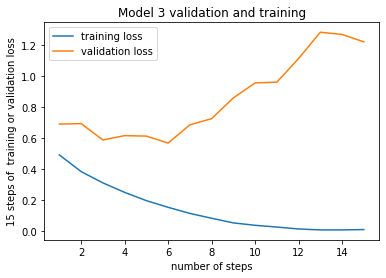

In [ ]:
#Plot the training and validation of the model3
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_model3)+1, 1), train_report_model3,label="training loss")
plt.plot(range(1, len(val_report_model3)+1, 1), val_report_model3,label="validation loss")

plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.title("Model 3 validation and training")
plt.legend()
plt.show()

# Q6 PLOT Model2 and Model 3 in one plot

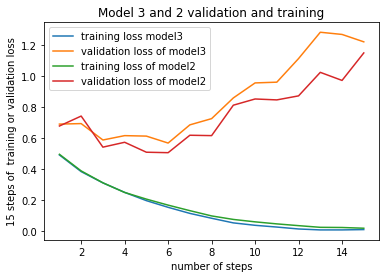

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_model3)+1, 1), train_report_model3,label="training loss model3")
plt.plot(range(1, len(val_report_model3)+1, 1), val_report_model3,label="validation loss of model3")
plt.plot(range(1, len(train_report_model2)+1, 1), train_report_model2,label="training loss of model2")
plt.plot(range(1, len(val_report_model2)+1, 1), val_report_model2,label="validation loss of model2")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.title("Model 3 and 2 validation and training")
plt.legend()
plt.show()

# MODEL IMPROVING


# PART A SELECTED, 

In [ ]:
import torch.nn as nn
import torch
from torchtext import data, datasets, vocab
class Text_glove(nn.Module):
    def __init__(self, txtvector, n_hidden, n_layers, dropout,f_value):
        super(Text_glove, self).__init__()
        self.vec_weights = txtvector.vocab.vectors
        self.emb = nn.Embedding.from_pretrained(self.vec_weights , freeze=f_value)
        self.LSTM = nn.LSTM(
                input_size=50,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=False
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        # outputs, hidden = self.LSTM(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        no_need, (hidden,_) = self.LSTM(packed_embedded)
        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)
        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

class random_weight_RNN(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(random_weight_RNN, self).__init__()
        self.word_emb = torch.FloatTensor(np.random.rand(n_vocab,embedding_dim))
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.emb.weight =  nn.Parameter(self.word_emb, requires_grad=True)
        self.LSTM = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=False
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        # outputs, hidden = self.LSTM(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        no_need, (hidden,_) = self.LSTM(packed_embedded)
        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)

        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
class random_rm(nn.Module):
    def __init__(self,n_vocab, embedding_dim, n_hidden, n_layers, dropout,f_value):
        super(random_rm, self).__init__()
        self.vec_weights = torch.FloatTensor(np.random.rand(n_vocab,embedding_dim))
        self.emb = nn.Embedding.from_pretrained(self.vec_weights , freeze=f_value)
        self.LSTM = nn.LSTM(
                input_size=50,
                hidden_size=n_hidden,
                num_layers=n_layers,
                #dropout=dropout,  # dropout between rnn layers, only effective with num of layer > 1
                batch_first=True,
                bidirectional=False
        )
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(n_hidden,1)
        self.sig = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        # outputs, hidden = self.LSTM(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        no_need, (hidden,_) = self.LSTM(packed_embedded)
        h1 = self.drop(hidden)
        h1 = self.fc1(h1)
        h1 = self.sig(h1)
        return h1
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

## This is the model 4

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
TEXT_g1 = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_g1 = Field(sequential=False, use_vocab=False, batch_first=True)

Train_g1, Test_g1= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', TEXT_g1),('label', label_g1)], skip_header=True)
TEXT_g1.build_vocab(Train_g1, vectors='glove.6B.50d', min_freq=2)

Train_g1_iter = BucketIterator(Train_g1, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
Test_g1_iter = BucketIterator(Test_g1, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
print(TEXT_g1.vocab.vectors.shape)
n_epochs = 15
val_loss = None
save_name = 'glove_model_4'
criterion = nn.BCELoss()
val_report_1 = []
train_report_1 = []
print(TEXT_g1.vocab)
glove_model_1 = Text_glove(TEXT_g1, 64, 1, 0.1, True).to(device)
optimizer = Adam(glove_model_1.parameters())
#start training
TRAIN(glove_model_1, Train_g1_iter, Test_g1_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_1, val_report_1)

torch.Size([7953, 50])
Epoch [1/15], Train Loss: 0.4867, Valid Loss: 0.7499, Valid accuracy0.5155
Model saved to glove_model_4
Epoch [2/15], Train Loss: 0.4256, Valid Loss: 0.6945, Valid accuracy0.6295
Model saved to glove_model_4
Epoch [3/15], Train Loss: 0.3775, Valid Loss: 0.6712, Valid accuracy0.6585
Model saved to glove_model_4
Epoch [4/15], Train Loss: 0.3494, Valid Loss: 0.6176, Valid accuracy0.6895
Model saved to glove_model_4
Epoch [5/15], Train Loss: 0.3311, Valid Loss: 0.5769, Valid accuracy0.7215
Model saved to glove_model_4
Epoch [6/15], Train Loss: 0.3077, Valid Loss: 0.5462, Valid accuracy0.7345
Model saved to glove_model_4
Epoch [7/15], Train Loss: 0.2911, Valid Loss: 0.7480, Valid accuracy0.6520
Epoch [8/15], Train Loss: 0.2820, Valid Loss: 0.5422, Valid accuracy0.7380
Model saved to glove_model_4
Epoch [9/15], Train Loss: 0.2598, Valid Loss: 0.5129, Valid accuracy0.7540
Model saved to glove_model_4
Epoch [10/15], Train Loss: 0.2506, Valid Loss: 0.7081, Valid accuracy0

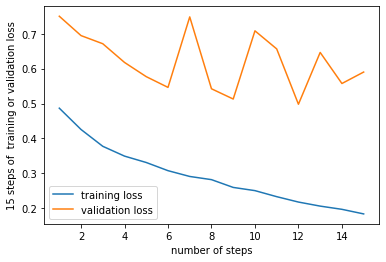

In [ ]:
#Q4 plot figure
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_1)+1, 1), train_report_1,label="training loss")
plt.plot(range(1, len(val_report_1)+1, 1), val_report_1,label="validation loss")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.legend()
plt.show()

## This is Model 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
TEXT_g1 = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_g1 = Field(sequential=False, use_vocab=False, batch_first=True)

Train_g1, Test_g1= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', TEXT_g1),('label', label_g1)], skip_header=True)
TEXT_g1.build_vocab(Train_g1, vectors='glove.6B.50d', min_freq=2)

Train_g1_iter = BucketIterator(Train_g1, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
Test_g1_iter = BucketIterator(Test_g1, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
print(TEXT_g1.vocab.vectors.shape)
n_epochs = 15
val_loss = None
save_name = 'glove_model_5'
criterion = nn.BCELoss()
val_report_2 = []
train_report_2 = []
print(TEXT_g1.vocab)
glove_model_1 = Text_glove(TEXT_g1, 64, 1, 0.1, False).to(device)
optimizer = Adam(glove_model_1.parameters())
#start training
TRAIN(glove_model_1, Train_g1_iter, Test_g1_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_2, val_report_2)

torch.Size([7953, 50])
Epoch [1/15], Train Loss: 0.4923, Valid Loss: 0.7086, Valid accuracy0.5745
Model saved to glove_model_5
Epoch [2/15], Train Loss: 0.3519, Valid Loss: 0.6134, Valid accuracy0.7050
Model saved to glove_model_5
Epoch [3/15], Train Loss: 0.2568, Valid Loss: 0.5472, Valid accuracy0.7485
Model saved to glove_model_5
Epoch [4/15], Train Loss: 0.1928, Valid Loss: 0.5229, Valid accuracy0.7820
Model saved to glove_model_5
Epoch [5/15], Train Loss: 0.1448, Valid Loss: 0.6163, Valid accuracy0.7855
Model saved to glove_model_5
Epoch [6/15], Train Loss: 0.1147, Valid Loss: 0.5095, Valid accuracy0.8175
Model saved to glove_model_5
Epoch [7/15], Train Loss: 0.0789, Valid Loss: 0.5612, Valid accuracy0.8040
Epoch [8/15], Train Loss: 0.0586, Valid Loss: 0.7012, Valid accuracy0.7990
Epoch [9/15], Train Loss: 0.0380, Valid Loss: 0.8126, Valid accuracy0.7920
Epoch [10/15], Train Loss: 0.0278, Valid Loss: 0.8615, Valid accuracy0.7885
Epoch [11/15], Train Loss: 0.0218, Valid Loss: 1.142

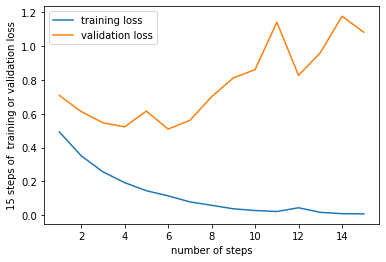

In [ ]:
#Q4 plot figure
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_2)+1, 1), train_report_2,label="training loss")
plt.plot(range(1, len(val_report_2)+1, 1), val_report_2,label="validation loss")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.legend()
plt.show()

In [ ]:
print(" distance between happy and good",abs(TEXT_g1.vocab.stoi['happy'] - TEXT_g1.vocab.stoi['good']))
print("distance between france and germany",abs(TEXT_g1.vocab.stoi['france'] - TEXT_g1.vocab.stoi['germany']))
print("distance between france and happy",abs(TEXT_g1.vocab.stoi['france'] - TEXT_g1.vocab.stoi['happy']))


 distance between happy and good 1212
distance between france and germany 352
distance between france and happy 1361


In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
TEXT_random = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_random = Field(sequential=False, use_vocab=False, batch_first=True)

Train_random, Test_random= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', TEXT_random),('label', label_random)], skip_header=True)
randome_vector = torch.rand(793,50)

TEXT_random.build_vocab(Train_random, min_freq=2)

Train_r_iter = BucketIterator(Train_random, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
Test_r_iter = BucketIterator(Test_random, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)

n_epochs = 15
val_loss = None
save_name = 'random_g_model'
criterion = nn.BCELoss()
val_report_3 = []
train_report_3 = []

random_model = random_rm(len(TEXT_random.vocab),50, 64, 1, 0.1,True).to(device)
optimizer = Adam(random_model.parameters())
#start training
TRAIN(random_model, Train_r_iter, Test_r_iter,  n_epochs, criterion, optimizer, val_loss, device, save_name, train_report_3, val_report_3)

Epoch [1/15], Train Loss: 0.5026, Valid Loss: 0.8501, Valid accuracy0.5000
Model saved to random_g_model
Epoch [2/15], Train Loss: 0.4928, Valid Loss: 0.8692, Valid accuracy0.5000
Epoch [3/15], Train Loss: 0.4868, Valid Loss: 0.8844, Valid accuracy0.5000
Epoch [4/15], Train Loss: 0.4794, Valid Loss: 0.8180, Valid accuracy0.5000
Epoch [5/15], Train Loss: 0.4770, Valid Loss: 0.8325, Valid accuracy0.5000
Epoch [6/15], Train Loss: 0.4565, Valid Loss: 0.8021, Valid accuracy0.5405
Model saved to random_g_model
Epoch [7/15], Train Loss: 0.4404, Valid Loss: 0.9027, Valid accuracy0.5035
Epoch [8/15], Train Loss: 0.4166, Valid Loss: 0.7208, Valid accuracy0.5990
Model saved to random_g_model
Epoch [9/15], Train Loss: 0.4042, Valid Loss: 0.6321, Valid accuracy0.6525
Model saved to random_g_model
Epoch [10/15], Train Loss: 0.3997, Valid Loss: 0.7121, Valid accuracy0.6420
Epoch [11/15], Train Loss: 0.3867, Valid Loss: 0.7923, Valid accuracy0.5370
Epoch [12/15], Train Loss: 0.3858, Valid Loss: 0.6627

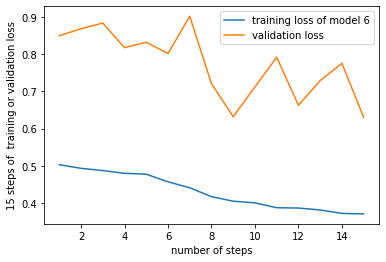

In [ ]:

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_report_3)+1, 1), train_report_3,label="training loss of model 6")
plt.plot(range(1, len(val_report_3)+1, 1), val_report_3,label="validation loss")

plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.legend()
plt.show()

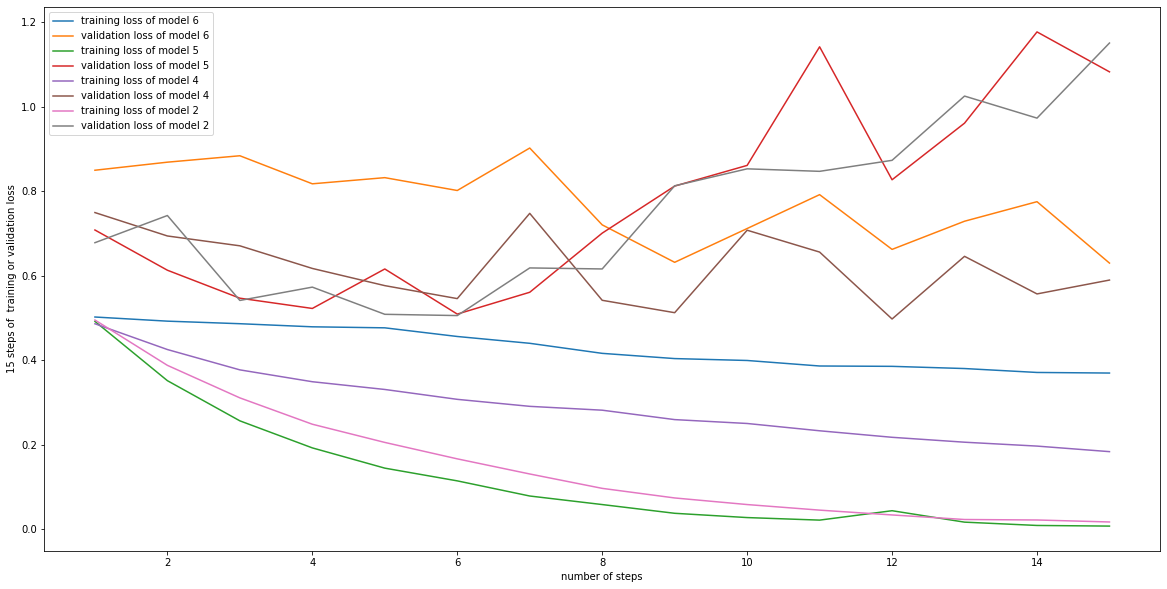

In [ ]:
#Q9a plot the trianing and validation losses of model2 ,4, 5
fig = plt.figure(figsize=(20, 10))
plt.plot(range(1, len(train_report_3)+1, 1), train_report_3,label="training loss of model 6")
plt.plot(range(1, len(val_report_3)+1, 1), val_report_3,label="validation loss of model 6")
plt.plot(range(1, len(train_report_2)+1, 1), train_report_2,label="training loss of model 5")
plt.plot(range(1, len(val_report_2)+1, 1), val_report_2,label="validation loss of model 5")
plt.plot(range(1, len(train_report_1)+1, 1), train_report_1,label="training loss of model 4")
plt.plot(range(1, len(val_report_1)+1, 1), val_report_1,label="validation loss of model 4")
plt.plot(range(1, len(train_report_model2)+1, 1), train_report_model2,label="training loss of model 2")
plt.plot(range(1, len(val_report_model2)+1, 1), val_report_model2,label="validation loss of model 2")
plt.ylabel("15 steps of  training or validation loss")
plt.xlabel("number of steps")
plt.legend(loc='upper left')
plt.show()

# Part D Model Ensemble , the best model selected is 5, 2, 1.


In [ ]:
def eval_average(model1,model2,model3,test_loader):

  with torch.no_grad():
    corr = 0
    for i, (inputs) in enumerate(test_loader):
      model1.eval()
      model2.eval()
      model3.eval()
      sent, sent_len = inputs.sentence
      labels = inputs.label

      sent = sent.to(device)
      sent_len = sent_len.to('cpu')
      labels = labels.to(device)
      outputs_1 = model1(sent,sent_len)
      outputs_2 = model2(sent, sent_len)
      outputs_3 = model3(sent, sent_len)
      labels = labels.unsqueeze(1)
      outputs_1 = outputs_1.squeeze(0)
      outputs_2 = outputs_2.squeeze(0)
      outputs_3 = outputs_3.squeeze(0)

                
      for j in range(len(outputs_1)):
        pred = outputs_1[j] + outputs_2[j] + outputs_3[j]
        pred = pred / 3
        if labels[j] == 1 and pred >= 0.5 :
          corr += 1
        if labels[j] == 0 and pred < 0.5 :
          corr += 1

  print("The accuracy :",corr/2000)


def weighted_averge(model1,model2,model3,test_loader):

  with torch.no_grad():
    corr = 0
    for i, (inputs) in enumerate(test_loader):
      model1.eval()
      model2.eval()
      model3.eval()
      sent, sent_len = inputs.sentence
      labels = inputs.label

      sent = sent.to(device)
      sent_len = sent_len.to('cpu')
      labels = labels.to(device)
      outputs_1 = model1(sent,sent_len)
      outputs_2 = model2(sent, sent_len)
      outputs_3 = model3(sent, sent_len)
      labels = labels.unsqueeze(1)
      outputs_1 = outputs_1.squeeze(0)
      outputs_2 = outputs_2.squeeze(0)
      outputs_3 = outputs_3.squeeze(0)

                
      for j in range(len(outputs_1)):


        x1 = 0.22
        x2 = 0.39
        x3 = 0.39
        pred = outputs_1[j]*x1  + outputs_2[j]*x2 + outputs_3[j]*x3
        if labels[j] == 1 and pred >= 0.5 :
          corr += 1
        if labels[j] == 0 and pred < 0.5 :
          corr += 1

  print("The accuracy :",corr/2000)



In [ ]:
model2 = Text_RNN_2(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer_model2 = Adam(model2.parameters())
load_checkpoint('gdrive/MyDrive/LSTM_model_2', model2, optimizer_model2)
### load model2

model5 = Text_glove(TEXT_g1, 64, 1, 0.1, False).to(device)
optimizer_model5 = Adam(model5.parameters())
load_checkpoint('gdrive/MyDrive/glove_model_5', model5, optimizer_model5)
###load model5

model1 = Text_RNN_1(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer_model1 = Adam(model1.parameters())
load_checkpoint('gdrive/MyDrive/model_1_GRU_model', model1, optimizer_model1)
###load model1 for checking

model4 = Text_glove(TEXT_g1, 64, 1, 0.1, True).to(device)
optimizer_model4 = Adam(model4.parameters())
load_checkpoint('gdrive/MyDrive/glove_model_4', model4, optimizer_model4)
##load model4
TEXT_test = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_test = Field(sequential=False, use_vocab=False, batch_first=True)

Train_test, Test_test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', TEXT_test),('label', label_test)], skip_header=True)
TEXT_test.build_vocab(Train_test, min_freq=2)

Train_test_iter = BucketIterator(Train_test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
Test_test_iter = BucketIterator(Test_test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)

eval_average(model2,model1,model5,Test_test_iter)


Model loaded from gdrive/MyDrive/LSTM_model_2, and best val accuracy 0.792
Model loaded from gdrive/MyDrive/glove_model_5, and best val accuracy 0.8175
Model loaded from gdrive/MyDrive/model_1_GRU_model, and best val accuracy 0.7855
Model loaded from gdrive/MyDrive/glove_model_4, and best val accuracy 0.7785
The accuracy : 0.8115


In [ ]:

TEXT_test = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_test = Field(sequential=False, use_vocab=False, batch_first=True)

Train_test, Test_test= TabularDataset.splits(path='gdrive/My Drive',train='new_train.csv', test='val.csv',format='csv', 
                                  fields=[ ('sentence', TEXT_test),('label', label_test)], skip_header=True)
TEXT_test.build_vocab(Train_test, min_freq=2)

Train_test_iter = BucketIterator(Train_test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)
Test_test_iter = BucketIterator(Test_test, batch_size=64, sort_key=lambda x: len(x.sentence),sort_within_batch=True,device=device)


weighted_averge(model1,model2,model5,Test_test_iter)

The accuracy : 0.818


### Threshold experiment 

In [ ]:
def weighted_averge_threshold(model1,model2,model3,test_loader):
  test_theshold = [0.3,0.4,0.48,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.7,0.8,0.9]
  best_accur = 0
  accur = 0
  thold = 0
  for x in test_theshold:
    with torch.no_grad():
      corr = 0
      for i, (inputs) in enumerate(test_loader):
        model1.eval()
        model2.eval()
        model3.eval()
        sent, sent_len = inputs.sentence
        labels = inputs.label

        sent = sent.to(device)
        sent_len = sent_len.to('cpu')
        labels = labels.to(device)
        outputs_1 = model1(sent,sent_len)
        outputs_2 = model2(sent, sent_len)
        outputs_3 = model3(sent, sent_len)
        labels = labels.unsqueeze(1)
        outputs_1 = outputs_1.squeeze(0)
        outputs_2 = outputs_2.squeeze(0)
        outputs_3 = outputs_3.squeeze(0)

                  
        for j in range(len(outputs_1)):

          x1 = 0.22
          x2 = 0.39
          x3 = 0.39
          pred = outputs_1[j]*x1  + outputs_2[j]*x2 + outputs_3[j]*x3
          if labels[j] == 1 and pred >= x :
            corr += 1
          if labels[j] == 0 and pred < x :
            corr += 1
      accur = corr/2000
      if accur > best_accur:
        best_accur = accur
        thold = x
    print("The accuracy :",corr/2000," for threshold ",x)
  print("the best accuracy :",best_accur," for threshold, ",thold)
  return thold

In [ ]:
opt_threshold = weighted_averge_threshold(model1,model2,model5,Test_test_iter)

The accuracy : 0.685  for threshold  0.3
The accuracy : 0.796  for threshold  0.4
The accuracy : 0.816  for threshold  0.48
The accuracy : 0.818  for threshold  0.5
The accuracy : 0.8165  for threshold  0.51
The accuracy : 0.816  for threshold  0.52
The accuracy : 0.815  for threshold  0.53
The accuracy : 0.8115  for threshold  0.54
The accuracy : 0.811  for threshold  0.55
The accuracy : 0.805  for threshold  0.56
The accuracy : 0.805  for threshold  0.57
The accuracy : 0.802  for threshold  0.58
The accuracy : 0.799  for threshold  0.59
The accuracy : 0.795  for threshold  0.6
The accuracy : 0.7665  for threshold  0.7
The accuracy : 0.7365  for threshold  0.8
The accuracy : 0.707  for threshold  0.9
the best accuracy : 0.818  for threshold,  0.5


#Q9 prediction

### Q9 get the Training set.

In [ ]:
# get the training set again . 
# this time put the labels position as original place
from sklearn.model_selection import train_test_split
df_train = pd.read_csv('gdrive/MyDrive/pa3/train.csv')
df_test = pd.read_csv('gdrive/MyDrive/pa3/test.csv')
print((df_train == 0).sum(axis=0)[0])
df_train_0 = df_train[0:(df_train == 0).sum(axis=0)[0]] # divide the training set into "0"
df_train_1 = df_train[(df_train == 0).sum(axis=0)[0]:] # get the labels with "1"
# split data seperately to get "1" and "0" validation set.
train_data_0, val_data_0 = train_test_split(df_train_0, test_size=1000, random_state=4211, shuffle=True)
train_data_1, val_data_1 = train_test_split(df_train_1, test_size=1000, random_state=4211, shuffle=True)

train_data = train_data_0.append(train_data_1, ignore_index =True)
val_data = val_data_0.append(val_data_1, ignore_index=True)

train_table = train_data.iloc[:,0]
train_data = train_data.iloc[:,-1]

val_table = val_data.iloc[:,0]
val_data = val_data.iloc[:,-1]

train_data = pd.concat([train_table, train_data], axis=1)
val_data = pd.concat([val_table, val_data], axis=1)

train_data.to_csv('gdrive/My Drive/train_pred.csv', index=False)

9375


### Q9 get the test set.

In [ ]:
from torch.utils.data import DataLoader
import pandas as pd
PATH = 'gdrive/MyDrive/pa3/'# change the path to the place you stored 'test.csv'

text_Field_test = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) 
label_Field_test = Field(sequential=False, use_vocab=False, batch_first=True)

## set those training and test set to the tabular dataset.
Test_set = TabularDataset('gdrive/MyDrive/pa3/test.csv', format='csv', fields=[('label', label_Field_test), ('sentence', text_Field_test)], skip_header=True )
Train_set = TabularDataset('gdrive/My Drive/train_pred.csv', format='csv', fields=[('label', label_Field_test), ('sentence', text_Field_test)], skip_header=True )
## build vocab using training set.
text_Field_test.build_vocab(Train_set, min_freq=2)
## read test file, for storage purpose
test_file = pd.read_csv(PATH + "test.csv")
## make test_set to be a iterator
test_itr = data.Iterator(Test_set, batch_size=1, device=device, shuffle=False,sort=False, sort_within_batch=False)


In [ ]:
## To check whether we get the correct order.
batch = next(iter(test_itr))
print('label tensor', batch.label.shape)
print(batch)
print(batch.label)
print()
sent, sent_len = batch.sentence
print('sentence length tensor', sent_len.shape)
print(sent_len)
print('sentence tensor', sent.shape)
print(sent)

label tensor torch.Size([1])

[torchtext.data.batch.Batch of size 1]
	[.label]:[torch.LongTensor of size 1]
	[.sentence]:('[torch.LongTensor of size 1x14]', '[torch.LongTensor of size 1]')
tensor([2])

sentence length tensor torch.Size([1])
tensor([14])
sentence tensor torch.Size([1, 14])
tensor([[  22,    6,  831,    0,    0,    0,    3,   32, 5244,  224,    0,    0,
            0,  886]])


###  Q9 Start prediction


In [ ]:
def pred_news(model1,model2,model3,test_loader,test_file,threshold):
  with torch.no_grad():
    idx = 0
    for i, (inputs) in enumerate(test_loader):
      model1.eval()
      model2.eval()
      model3.eval()
      sent, sent_len = inputs.sentence
      sent = sent.to(device)
      sent_len = sent_len.to('cpu')

      outputs_1 = model1(sent,sent_len)
      outputs_2 = model2(sent, sent_len)
      outputs_3 = model3(sent, sent_len)

      outputs_1 = outputs_1.squeeze(0)
      outputs_2 = outputs_2.squeeze(0)
      outputs_3 = outputs_3.squeeze(0)

      
      for j in range(len(outputs_1)):
        x1 = 0.22
        x2 = 0.39
        x3 = 0.39
        pred = outputs_1[j]*x1  + outputs_2[j]*x2 + outputs_3[j]*x3
        if pred >= threshold :
          test_file.iloc[idx, 0] = 1 
        if pred < threshold :
          test_file.iloc[idx, 0] = 0
        idx += 1
  return test_file



### Load model, Part D's weighted average is prefered

In [ ]:
model2 = Text_RNN_2(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer_model2 = Adam(model2.parameters())
load_checkpoint('gdrive/MyDrive/LSTM_model_2', model2, optimizer_model2)
### load model2

model5 = Text_glove(TEXT_g1, 64, 1, 0.1, False).to(device)
optimizer_model5 = Adam(model5.parameters())
load_checkpoint('gdrive/MyDrive/glove_model_5', model5, optimizer_model5)
###load model5

model1 = Text_RNN_1(len(txt_field.vocab), 50, 64, 1, 0.1).to(device)
optimizer_model1 = Adam(model1.parameters())
load_checkpoint('gdrive/MyDrive/model_1_GRU_model', model1, optimizer_model1)
###load model1

model4 = Text_glove(TEXT_g1, 64, 1, 0.1, True).to(device)
optimizer_model4 = Adam(model4.parameters())
load_checkpoint('gdrive/MyDrive/glove_model_4', model4, optimizer_model4)

##load model4

Model loaded from gdrive/MyDrive/LSTM_model_2, and best val accuracy 0.792
Model loaded from gdrive/MyDrive/glove_model_5, and best val accuracy 0.8175
Model loaded from gdrive/MyDrive/model_1_GRU_model, and best val accuracy 0.7855
Model loaded from gdrive/MyDrive/glove_model_4, and best val accuracy 0.7785


0.7785

### Q9 convert df to psv, pred

In [ ]:
test_file = pred_news(model1,model2,model5,test_itr,test_file,opt_threshold)
test_file.to_csv('pred.csv', index=False)